In [1]:
import sys
print(sys.executable)
import warnings
warnings.filterwarnings('ignore')

C:\Users\Summer\miniconda3\envs\data_analysis\python.exe


In [2]:
import tushare as ts
import pandas as pd
from datetime import datetime, timedelta
import time

ts.set_token('4c16742e8a98b00a7308d158e35e43a05eb0b5d2f8874bcf9549520b')
pro = ts.pro_api()

In [3]:
end_date = datetime.now().strftime('%Y%m%d')
start_date = (datetime.now() - timedelta(days=180)).strftime('%Y%m%d')

In [4]:
tmp = pro.sge_basic(ts_code='Au99.95')
tmp

,ts_code,ts_name,trade_type,t_unit,p_unit,min_change,price_limit,min_vol,max_vol,trade_mode,margin_rate,liq_rate,trade_time,list_date
0,Au99.95,黄金9995,现货实盘交易,1000.0,1.0,0.01,30.0,1,500,T+0,None,None,白天：9:00至15:30，夜间:19:50 至次日 02:30,20061030


In [5]:
df_spot = pro.sge_daily(
    ts_code='Au99.95',
    start_date=start_date,
    end_date=end_date,
    fields='trade_date,close'
)
df_spot

,trade_date,close
0,20250627,763.41
1,20250626,772.13
2,20250625,771.50
3,20250624,770.55
4,20250623,777.66
...,...,...
113,20250106,622.77
114,20250103,628.50
115,20250102,NaN
116,20241231,615.98


In [6]:
tmp=pro.fut_basic(exchange='SHFE')
gold_9995_df = tmp[tmp['name'].str.contains('黄金')]
gold_9995_df

,ts_code,symbol,exchange,name,fut_code,multiplier,trade_unit,per_unit,quote_unit,quote_unit_desc,d_mode_desc,list_date,delist_date,d_month,last_ddate
3310,AU.SHF,AU,SHFE,黄金主力,AU,None,None,NaN,None,None,None,None,None,None,None


In [7]:
# 获取期货主力合约数据
df_main_future = pro.fut_daily(
    ts_code='AU.SHF',
    start_date=start_date,
    end_date=end_date,
    fields='trade_date,close,vol,oi'
)

df_main_future

,trade_date,close,vol,oi
0,20250627,766.40,169217.0,129822.0
1,20250626,775.28,128026.0,135267.0
2,20250625,773.94,159583.0,145732.0
3,20250624,771.86,248445.0,147344.0
4,20250623,781.30,158979.0,152462.0
...,...,...,...,...
113,20250106,624.92,178204.0,95625.0
114,20250103,627.96,175468.0,102944.0
115,20250102,622.40,86999.0,103372.0
116,20241231,617.60,185333.0,104047.0


In [8]:
df_holding = pro.fut_holding(
    symbol='AU',
    start_date=start_date,
    end_date=end_date,
    fields='broker, trade_date,long_chg,short_chg'
)
df_holding = df_holding[df_holding['broker']=='期货公司']
df_holding = df_holding[['trade_date','long_chg','short_chg']]
df_holding

,trade_date,long_chg,short_chg
0,20250627,1939,5097
2,20250626,745,1202
4,20250625,-2885,976
6,20250624,-4865,-3734
8,20250623,1359,-457
...,...,...,...
226,20250106,-5013,2908
228,20250103,14946,11461
230,20250102,8405,2144
232,20241231,-2606,-2621


In [9]:
df_combined = pd.merge(
    left=df_main_future,      
    right=df_spot,             
    on='trade_date',           
    how='left',                
    suffixes=('_fut', '_spot') 
)

df_combined = pd.merge(
    left=df_combined,      
    right=df_holding,       
    on='trade_date',   
    how='left',         
)
df_combined['base'] = df_combined['close_fut'] - df_combined['close_spot']
df_combined

,trade_date,close_fut,vol,oi,close_spot,long_chg,short_chg,base
0,20250627,766.40,169217.0,129822.0,763.41,1939,5097,2.99
1,20250626,775.28,128026.0,135267.0,772.13,745,1202,3.15
2,20250625,773.94,159583.0,145732.0,771.50,-2885,976,2.44
3,20250624,771.86,248445.0,147344.0,770.55,-4865,-3734,1.31
4,20250623,781.30,158979.0,152462.0,777.66,1359,-457,3.64
...,...,...,...,...,...,...,...,...
113,20250106,624.92,178204.0,95625.0,622.77,-5013,2908,2.15
114,20250103,627.96,175468.0,102944.0,628.50,14946,11461,-0.54
115,20250102,622.40,86999.0,103372.0,NaN,8405,2144,NaN
116,20241231,617.60,185333.0,104047.0,615.98,-2606,-2621,1.62


In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# 转换日期格式
df_combined['date'] = pd.to_datetime(df_combined['trade_date'], format='%Y%m%d')
df_combined.set_index('date', inplace=True)

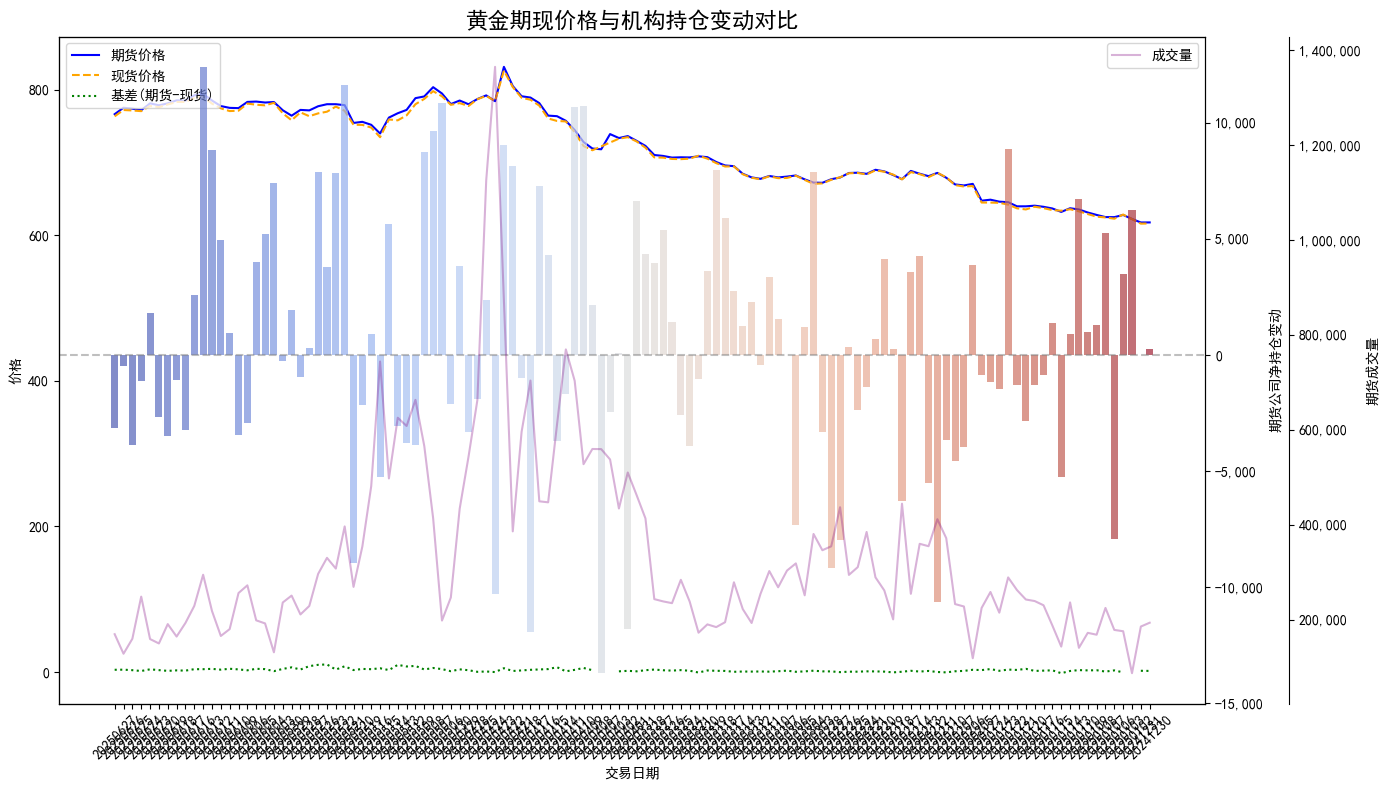

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 创建画布和主坐标轴
fig, ax1 = plt.subplots(figsize=(14, 8))

# 绘制价格双折线（期现价格）
sns.lineplot(data=df_combined, x='trade_date', y='close_fut', ax=ax1, color='blue', label='期货价格')
sns.lineplot(data=df_combined, x='trade_date', y='close_spot', ax=ax1, color='orange', label='现货价格', linestyle='--')

# 设置主Y轴标签和标题
ax1.set_ylabel('价格')
ax1.set_xlabel('交易日期')
ax1.set_title('黄金期现价格与机构持仓变动对比', fontsize=16)

# 创建第二Y轴用于持仓数据
ax2 = ax1.twinx()
sns.barplot(data=df_combined, x='trade_date', y=df_combined['long_chg'] - df_combined['short_chg'], 
            ax=ax2, palette='coolwarm', alpha=0.7)

# 设置第二Y轴标签
ax2.set_ylabel('期货公司净持仓变动')

# basis添加价格差（基差）
ax1.plot(df_combined['trade_date'], df_combined['base'], color='green', linestyle=':', label='基差(期货-现货)')

# 旋转日期标签避免重叠
plt.setp(ax1.get_xticklabels(), rotation=45)

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# 添加辅助线（净持仓变动为0的位置）
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# 添加成交量数据（使用第三个坐标轴）
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # 将第三轴向右移动
sns.lineplot(data=df_combined, x='trade_date', y='vol', ax=ax3, color='purple', alpha=0.3, label='成交量')
ax3.set_ylabel('期货成交量')

# 设置Y轴格式（显示为数值）
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# 紧凑布局
plt.tight_layout()
plt.show()

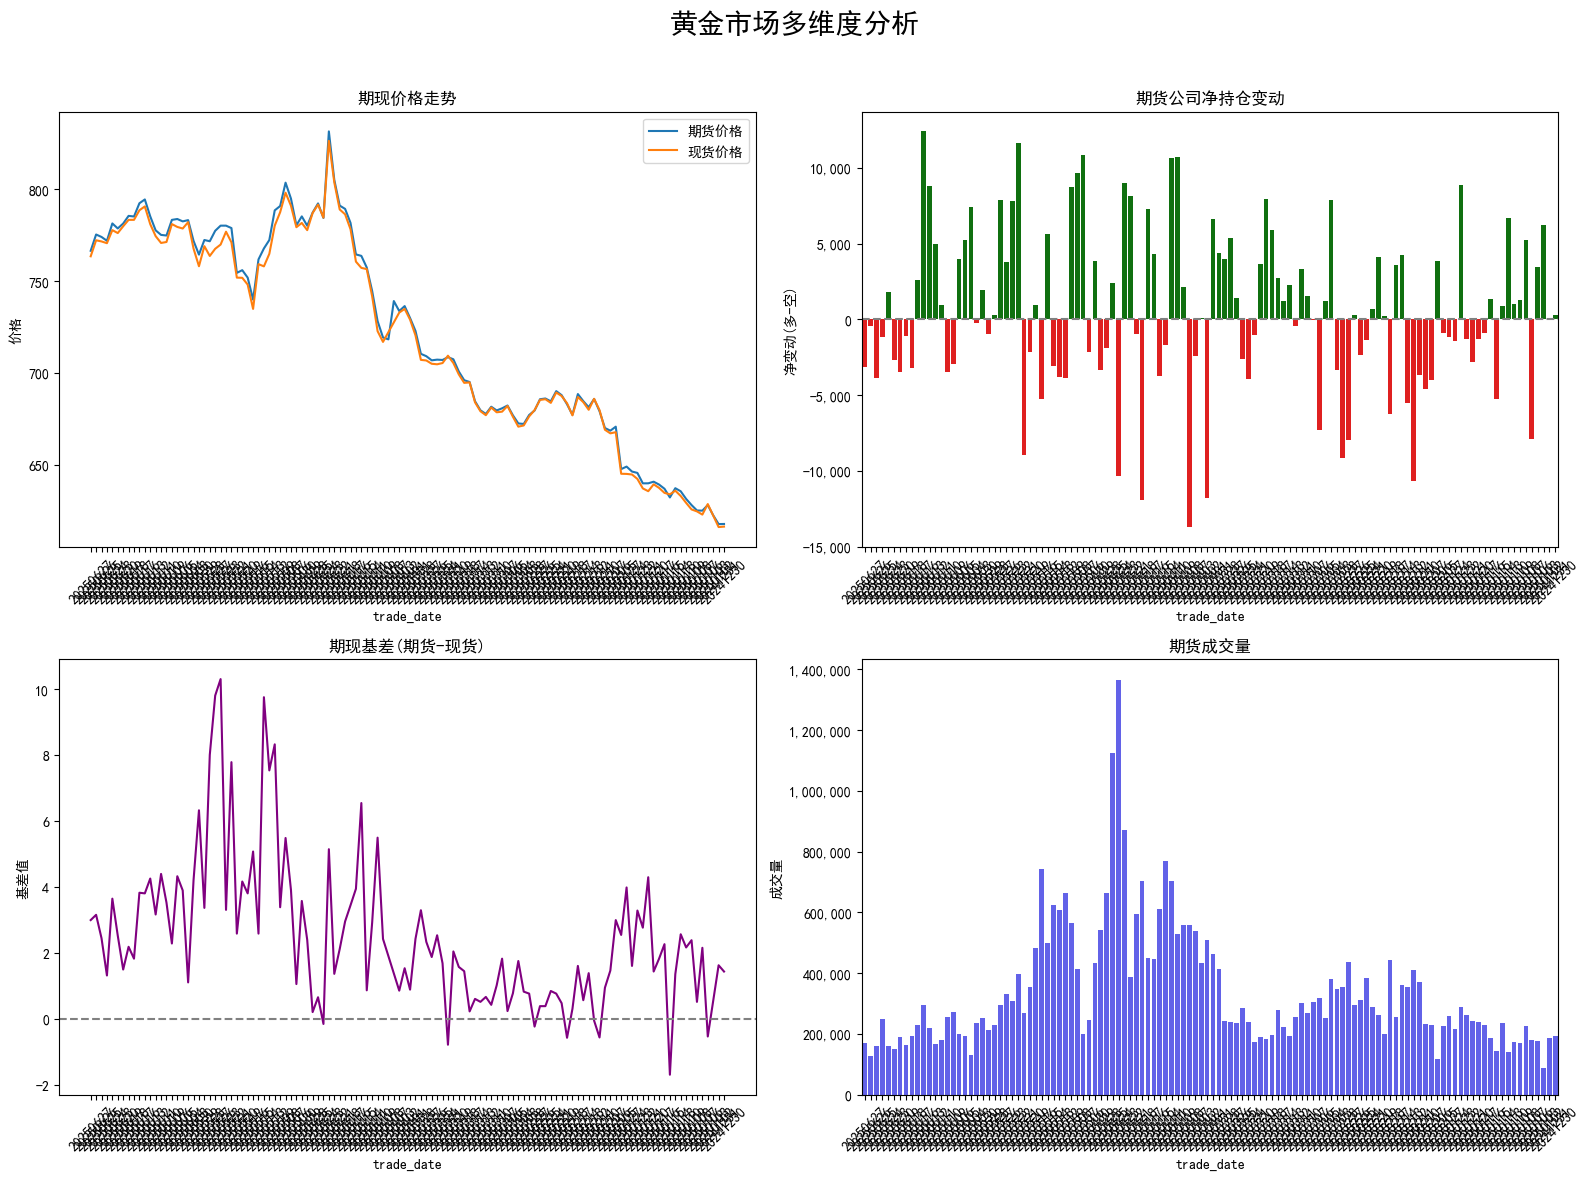

In [13]:
# 创建2x2子图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. 期现价格对比
sns.lineplot(data=df_combined, x='trade_date', y='close_fut', ax=ax1, label='期货价格')
sns.lineplot(data=df_combined, x='trade_date', y='close_spot', ax=ax1, label='现货价格')
ax1.set_title('期现价格走势')
ax1.set_ylabel('价格')

# 2. 净持仓变动（柱状图）
net_position = df_combined['long_chg'] - df_combined['short_chg']
colors = ['red' if val < 0 else 'green' for val in net_position]
sns.barplot(data=df_combined, x='trade_date', y=net_position, ax=ax2, palette=colors)
ax2.axhline(0, color='gray', linestyle='--')
ax2.set_title('期货公司净持仓变动')
ax2.set_ylabel('净变动(多-空)')

# 3. 期现基差（期货-现货）
sns.lineplot(data=df_combined, x='trade_date', y='base', ax=ax3, color='purple')
ax3.axhline(0, color='gray', linestyle='--')
ax3.set_title('期现基差(期货-现货)')
ax3.set_ylabel('基差值')

# 4. 成交量
sns.barplot(data=df_combined, x='trade_date', y='vol', ax=ax4, color='blue', alpha=0.7)
ax4.set_title('期货成交量')
ax4.set_ylabel('成交量')

# 旋转所有x轴标签
for ax in [ax1, ax2, ax3, ax4]:
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# 添加整体标题
fig.suptitle('黄金市场多维度分析', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为总标题留空间
plt.show()

In [14]:
username = "root"
password = "wxzWXZ1799824178"
host = "localhost"
database_name = "gold_analysis"
table_name = "gold" 
connection_string = f"mysql+mysqlconnector://{username}:{password}@{host}/{database_name}"

In [15]:
from sqlalchemy import create_engine
engine = create_engine(connection_string)

In [16]:
df_combined.to_sql(
    name=table_name,
    con=engine,
    index=False,  # 不保存pandas索引
    if_exists='replace',  # 根据你的需要选择
    chunksize=1000  # 分块写入提高效率
)

print(f"数据已成功写入MySQL表 '{table_name}'")

数据已成功写入MySQL表 'gold'
